In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import xgboost as xgb

In [21]:
# Step 1: Load the dataset
data = pd.read_csv('crypto_yearly_data.csv')

# Drop unnecessary columns
data = data.drop('year', axis=1)

In [22]:
# Create lag features (e.g., past 100 days' close prices as features)
def create_lag_features(data, target_column, n_lags):
    for lag in range(1, n_lags + 1):
        data[f'{target_column}_lag_{lag}'] = data[target_column].shift(lag)
    data = data.dropna()  # Remove rows with NaN values created by the lag features
    return data


In [23]:
# Create lag features for the "close" column
n_lags = 100
data = create_lag_features(data, 'close', n_lags)


C:\Users\Muhammad Aqeel\AppData\Local\Temp\ipykernel_14196\2092996551.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{target_column}_lag_{lag}'] = data[target_column].shift(lag)


In [24]:
# Step 2: Prepare the data for training
# Extract features and target
features = data.drop('close', axis=1).values
labels = data['close'].values

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Scale features using MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [27]:
# Convert data to DMatrix format (required for xgb.train())
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set up parameters for XGBoost
params = {
    "objective": "reg:squarederror",  # Regression objective
    "learning_rate": 0.01,  # Learning rate,  
    "max_depth": 6, # Depth of each tree
    "subsample": 0.8, # Subsample ratio of the training data
    "colsample_bytree": 0.8,# Subsample ratio of columns
    "seed": 42,
}

# Train the model with early stopping
print("Training the XGBoost model...")
xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,  # Maximum number of boosting rounds
    evals=[(dtest, "eval")],  # Evaluation set
    early_stopping_rounds=50,  # Stops if no improvement
    verbose_eval=True,  # Show training progress
)



Training the XGBoost model...
[0]	eval-rmse:15917.00442
[1]	eval-rmse:15757.87907
[2]	eval-rmse:15600.35379
[3]	eval-rmse:15444.40121
[4]	eval-rmse:15290.00426
[5]	eval-rmse:15137.15266
[6]	eval-rmse:14985.83879
[7]	eval-rmse:14836.03338
[8]	eval-rmse:14687.72676
[9]	eval-rmse:14540.90629
[10]	eval-rmse:14395.54839
[11]	eval-rmse:14251.64653
[12]	eval-rmse:14109.18754
[13]	eval-rmse:13968.14178
[14]	eval-rmse:13828.50808
[15]	eval-rmse:13690.26654
[16]	eval-rmse:13553.41597
[17]	eval-rmse:13417.93126
[18]	eval-rmse:13283.79878
[19]	eval-rmse:13151.01025
[20]	eval-rmse:13019.54177
[21]	eval-rmse:12889.39386
[22]	eval-rmse:12760.54694
[23]	eval-rmse:12632.98746
[24]	eval-rmse:12506.70787
[25]	eval-rmse:12381.68716
[26]	eval-rmse:12257.91905
[27]	eval-rmse:12135.38000
[28]	eval-rmse:12014.06853
[29]	eval-rmse:11893.97423
[30]	eval-rmse:11775.08016
[31]	eval-rmse:11657.37165
[32]	eval-rmse:11540.85095
[33]	eval-rmse:11425.50149
[34]	eval-rmse:11311.29513
[35]	eval-rmse:11198.23246
[36]	eva

In [30]:
# Make predictions
y_pred = xgb_model.predict(dtest)

# Evaluate metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nModel Performance:")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")


Model Performance:
Mean Absolute Error (MAE): 53.08580561891257
Mean Squared Error (MSE): 20499.998016093505
Root Mean Squared Error (RMSE): 143.17820370466137
R² Score: 0.999920694272594


C:\Users\Muhammad Aqeel\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


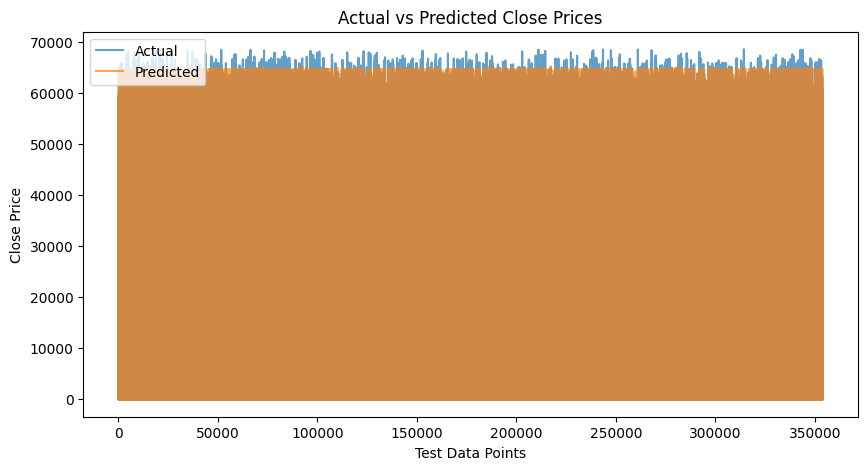

In [31]:
# Step 5: Visualize predictions vs actual
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(y_test, label="Actual", alpha=0.7)
plt.plot(y_pred, label="Predicted", alpha=0.7)
plt.legend()
plt.title("Actual vs Predicted Close Prices")
plt.xlabel("Test Data Points")
plt.ylabel("Close Price")
plt.show()

In [32]:
# Step 6: Save the model
xgb_model.save_model("xgboost_crypto_model.json")
print("XGBoost model saved to 'xgboost_crypto_model.json'.")


XGBoost model saved to 'xgboost_crypto_model.json'.
